In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import time

In [4]:
from rxrmask.core import (
    Atom,
    Structure,
    FormFactorLocalDB,
    ParametersContainer,
    FormFactorModel,
    FormFactorVacancy,
    ReflectivityData,
    create_compound,
)
from rxrmask.utils import (
    plot_reflectivity,
    plot_energy_scan,
    plot_density_profile,
    get_density_profile_from_element_data,
)
from rxrmask.backends import (
    PRReflectivityBackend,
    PRParallelReflectivityBackend,
)
from rxrmask.optimization import (
    RXRModel,
    RXRFitter,
    NelderMeadOptimizer,
    LBFGSOptimizer,
    DifferentialEvolutionOptimizer,
    LeastSquaresOptimizer,
)

In [5]:
def set_compound_params(structure: Structure, fit: bool):
    for compound in structure.compounds:
        compound.thickness.fit = fit
        compound.roughness.fit = fit
        compound.prev_roughness.fit = fit
        compound.density.fit = fit
        compound.magnetic_density.fit = fit

In [6]:
mn_ff = FormFactorLocalDB(element="Mn", is_magnetic=False)
o_ff = FormFactorLocalDB(element="O", is_magnetic=False)
sr_ff = FormFactorLocalDB(element="Sr", is_magnetic=False)
ti_ff = FormFactorLocalDB(element="Ti", is_magnetic=False)
c_ff = FormFactorLocalDB(element="C", is_magnetic=False)
la_ff = FormFactorLocalDB(element="La", is_magnetic=False)

la_atom = Atom(
    Z=57,
    name="La",
    ff=la_ff,
)
mn_atom = Atom(
    Z=25,
    name="Mn",
    ff=mn_ff,
)
o_atom = Atom(
    Z=8,
    name="O",
    ff=o_ff,
)
sr_atom = Atom(
    Z=38,
    name="Sr",
    ff=sr_ff,
)
ti_atom = Atom(
    Z=22,
    name="Ti",
    ff=ti_ff,
)
c_atom = Atom(
    Z=6,
    name="C",
    ff=c_ff,
)
x1_atom = Atom(
    Z=0,
    name="X1",
    ff=c_ff,
)
x2_atom = Atom(
    Z=0,
    name="X2",
    ff=c_ff,
)

In [7]:
parameters_container = ParametersContainer()

comp_SrTiO3 = create_compound(
    parameters_container=parameters_container,
    name="SrTiO3",
    formula="Sr:1,Ti:1,O:3",
    thickness=50.0,
    density=5.12,
    atoms=[sr_atom, ti_atom, o_atom],
    roughness=0.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
comp_LaMnO3 = create_compound(
    parameters_container=parameters_container,
    name="LaMnO3",
    formula="La:1,Mn:1,O:3",
    thickness=8.0,
    density=5.52,
    atoms=[la_atom, mn_atom, o_atom],
    roughness=4.0,
    prev_roughness=0.0,
    linked_prev_roughness=False,
)
comp_CCO = create_compound(
    parameters_container=parameters_container,
    name="CO2",
    formula="X1:1,X2:1,O:2",
    thickness=15.0,
    density=2.0,
    atoms=[x1_atom, x2_atom, o_atom],
    roughness=1.0,
    prev_roughness=0.0,
    linked_prev_roughness=True,
)

struc = Structure(name=f"Test Structure", n_compounds=3, params_container=parameters_container)
struc.add_compound(0, comp_SrTiO3)
struc.add_compound(1, comp_LaMnO3)
struc.add_compound(2, comp_CCO)
struc.validate_compounds()
struc.create_layers(step=0.1)

model = RXRModel(structure=struc, parameters_container=parameters_container)
set_compound_params(model.structure, fit=True)

In [8]:
init_params = model.parameters_container.get_fit_vector()
print(f"Initial parameters: {init_params}")
for param in model.parameters_container.parameters:
    if param.fit:
        print(f"{param.name}: {param.value}")

Initial parameters: [50.0, 5.12, 0.0, 0.0, 0.0, 8.0, 5.52, 0.0, 4.0, 0.0, 15.0, 2.0, 0.0, 1.0, 1.0, 0.0]
SrTiO3-thickness: 50.0
SrTiO3-density: 5.12
SrTiO3-magnetic_density: 0.0
SrTiO3-roughness: 0.0
SrTiO3-prev_roughness: 0.0
LaMnO3-thickness: 8.0
LaMnO3-density: 5.52
LaMnO3-magnetic_density: 0.0
LaMnO3-roughness: 4.0
LaMnO3-prev_roughness: 0.0
CO2-thickness: 15.0
CO2-density: 2.0
CO2-magnetic_density: 0.0
CO2-roughness: 1.0
R_scale: 1.0
R_offset: 0.0


# EXAPLE DATA TO FIT

---
    Initial parameters: [50.0, 5.12, 0.0, 0.0, 0.0, 10.0, 6.52, 0.0, 4.0, 0.0, 10.0, 5.0, 0.0, 4.0, 1.0, 0.0]
    SrTiO3-thickness: 50.0
    SrTiO3-density: 5.12
    SrTiO3-magnetic_density: 0.0
    SrTiO3-roughness: 0.0
    SrTiO3-prev_roughness: 0.0
    LaMnO3-thickness: 10.0
    LaMnO3-density: 6.52
    LaMnO3-magnetic_density: 0.0
    LaMnO3-roughness: 4.0
    LaMnO3-prev_roughness: 0.0
    CO2-thickness: 10.0
    CO2-density: 5.0
    CO2-magnetic_density: 0.0
    CO2-roughness: 4.0
    R_scale: 1.0
    R_offset: 0.0

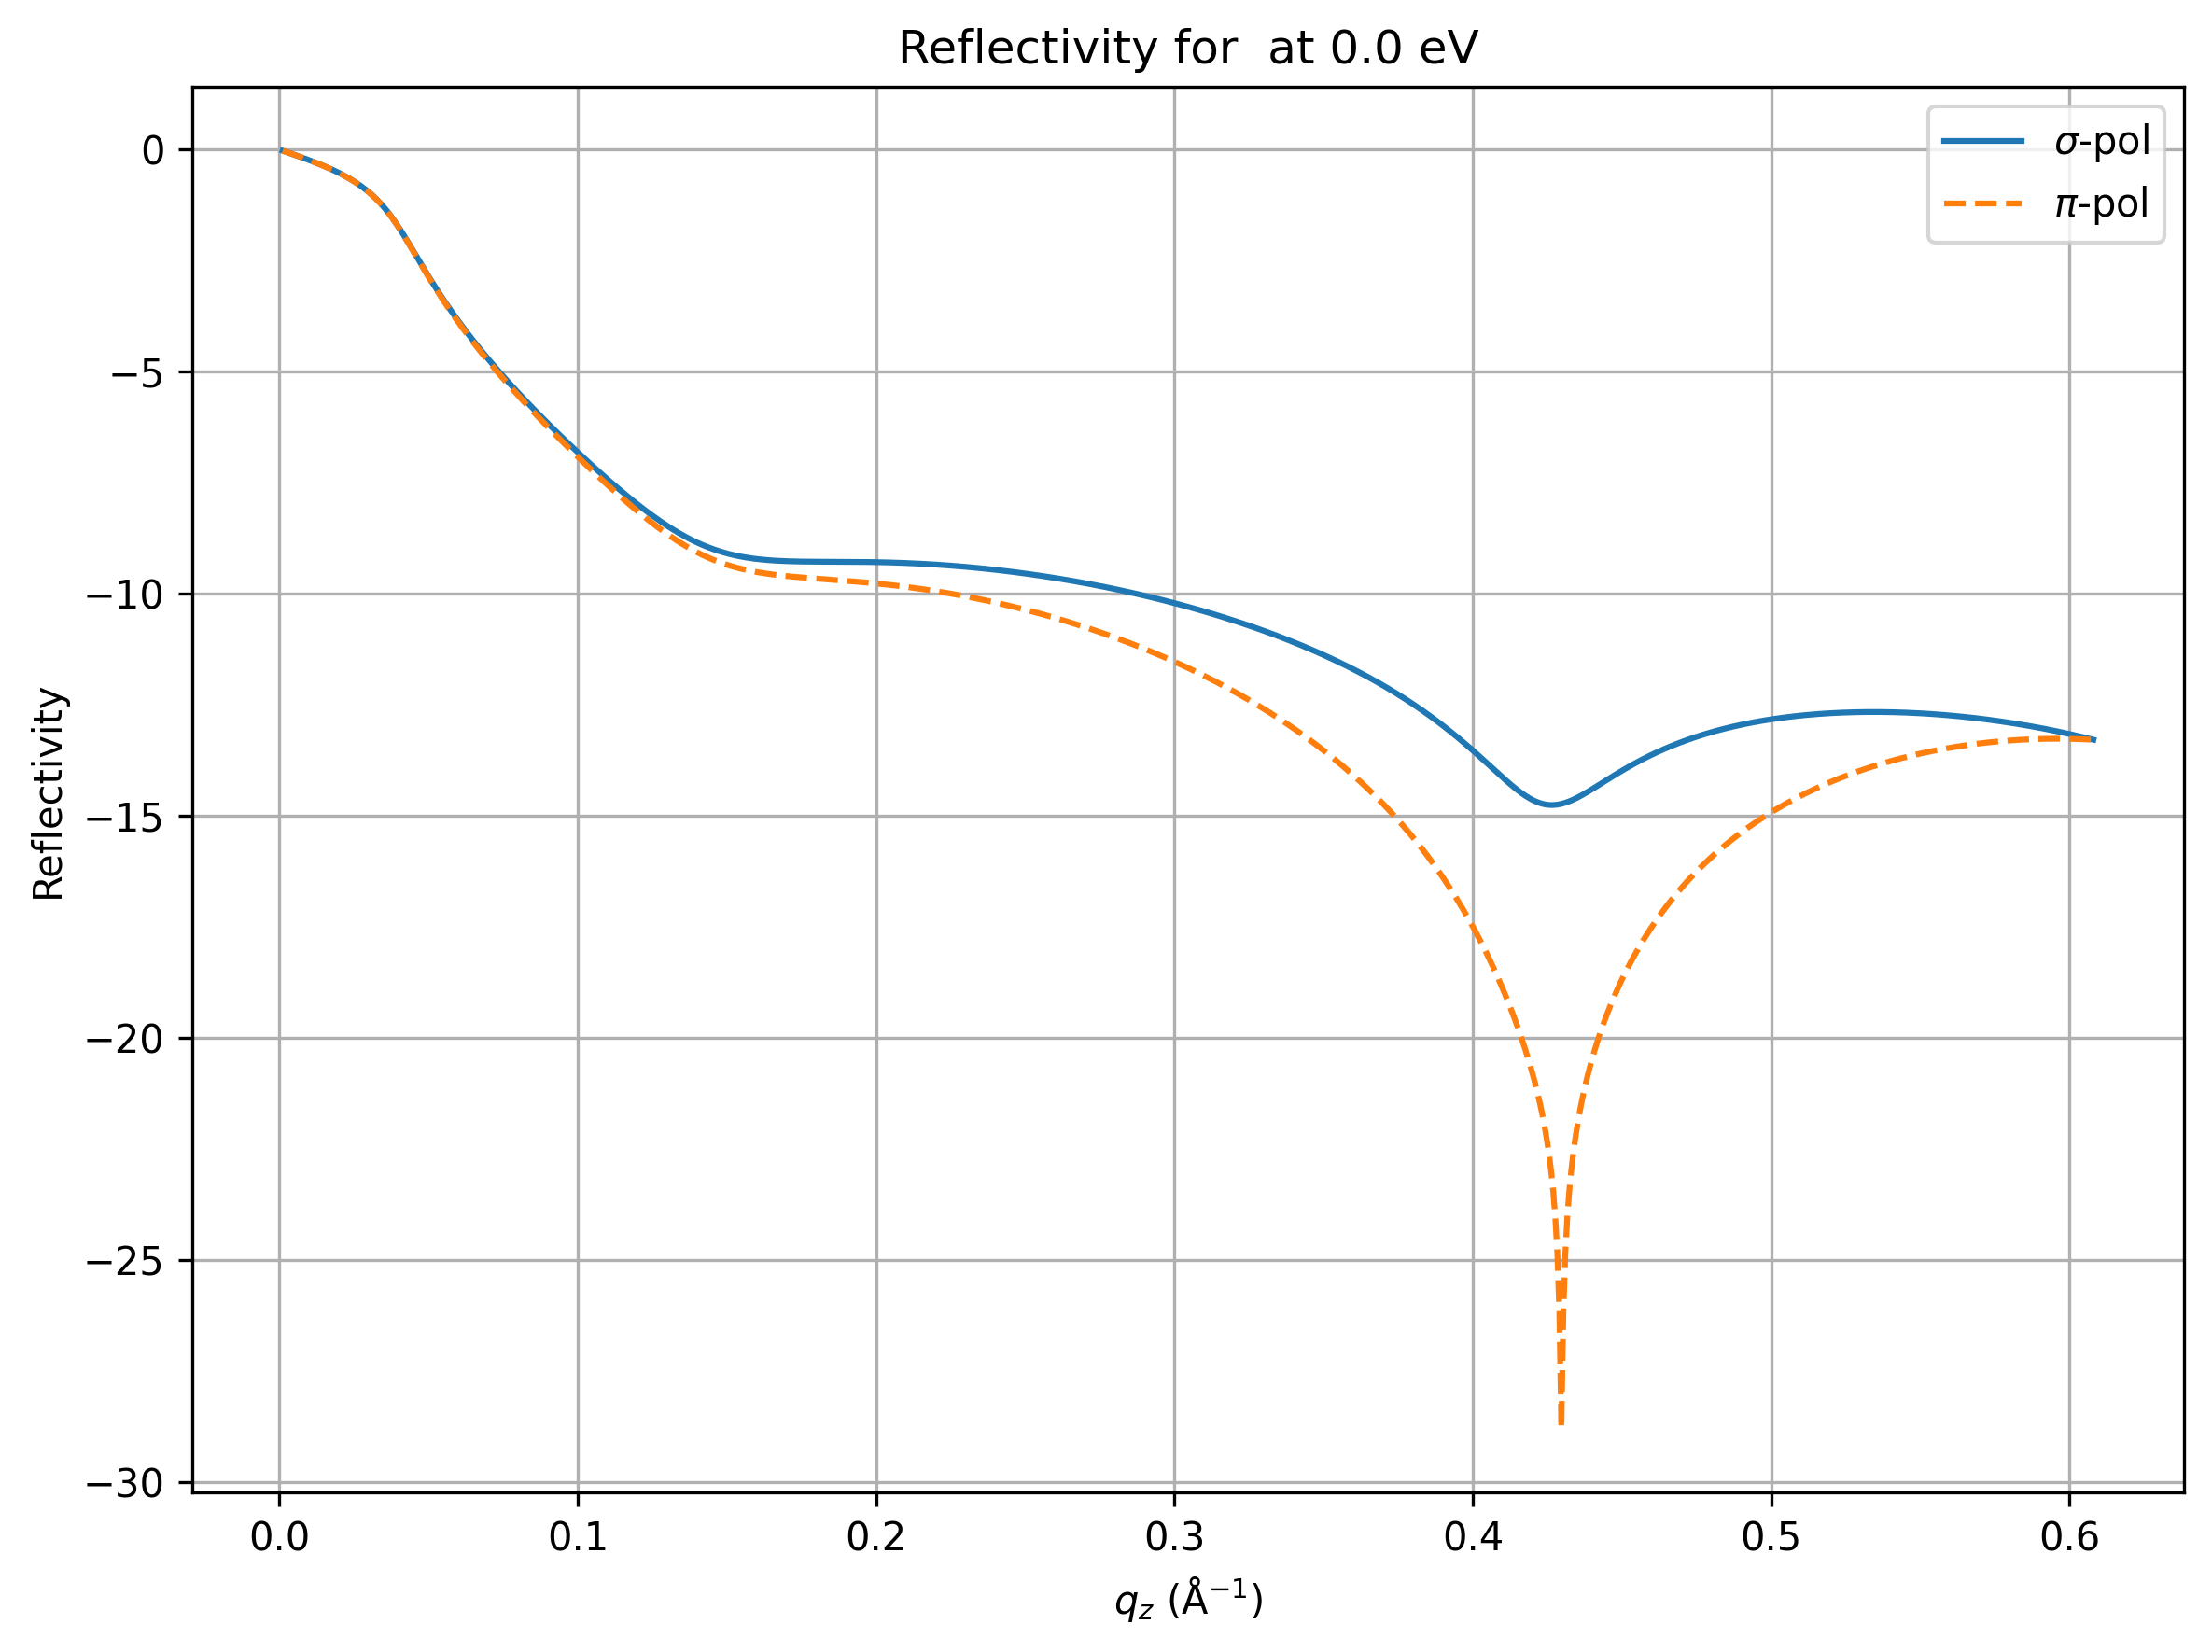

In [12]:
backend = PRReflectivityBackend()
model.set_reflectivity_backend(backend)

E_eV = 600
Theta = np.linspace(0.1, 89.1, num=1001)
qz = np.sin(Theta * np.pi / 180) * (E_eV * 0.001013546143)

initial_ref = model.compute_reflectivity(qz, E_eV)
plot_reflectivity(initial_ref.qz, initial_ref.R_s, initial_ref.R_p, initial_ref.energy, "")


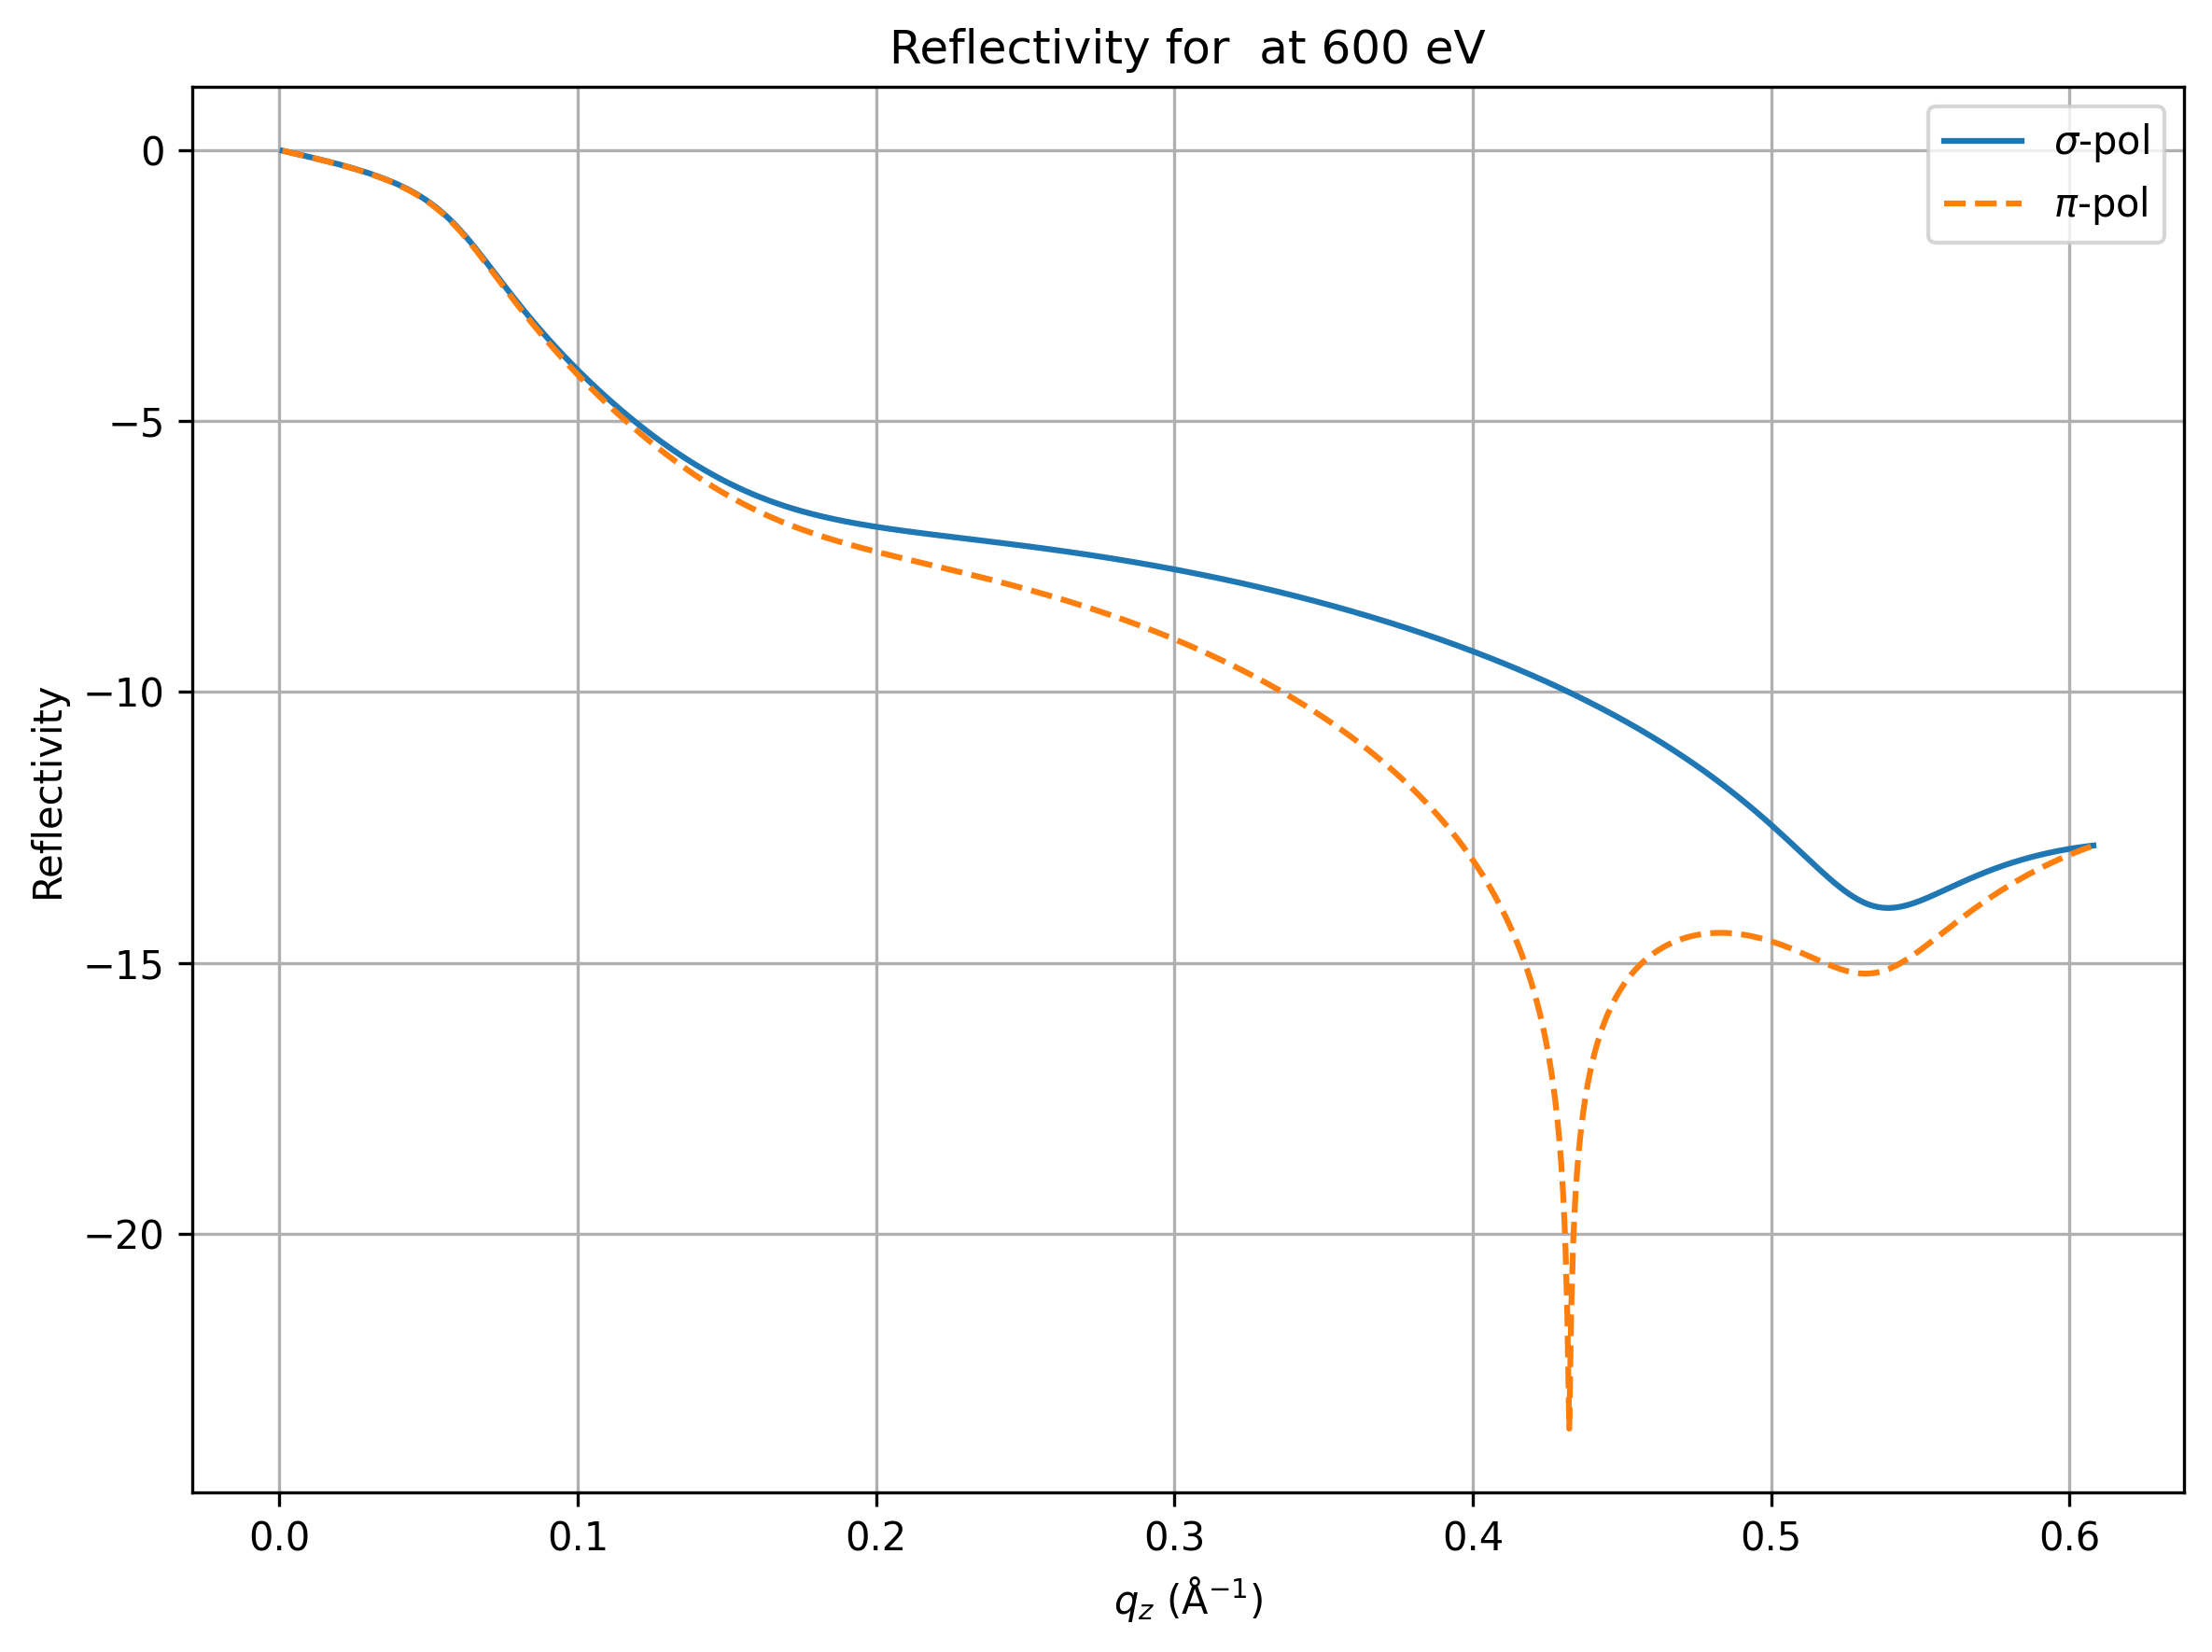

In [9]:
file_path = "./test_data.txt"
data = np.loadtxt(file_path)
qz, R_Sgo, R_Pgo = data.T

experimental_data = ReflectivityData()
experimental_data.energy = 600
experimental_data.qz = qz
experimental_data.R_s = R_Sgo
experimental_data.R_p = R_Pgo

plot_reflectivity(experimental_data.qz, experimental_data.R_s, experimental_data.R_p, experimental_data.energy, "")

Initial parameters: [5.12, 0.0, 0.0, 0.0, 8.0, 5.52, 0.0, 4.0, 0.0, 15.0, 2.0, 0.0, 1.0, 1.0, 0.0]
SrTiO3-density: 5.12
SrTiO3-magnetic_density: 0.0
SrTiO3-roughness: 0.0
SrTiO3-prev_roughness: 0.0
LaMnO3-thickness: 8.0
LaMnO3-density: 5.52
LaMnO3-magnetic_density: 0.0
LaMnO3-roughness: 4.0
LaMnO3-prev_roughness: 0.0
CO2-thickness: 15.0
CO2-density: 2.0
CO2-magnetic_density: 0.0
CO2-roughness: 1.0
R_scale: 1.0
R_offset: 0.0


/Users/niaggar/Developer/mitacs/rxr-mask/rxrmask/optimization/rxr.py:59: RuntimeWarning: invalid value encountered in log
  r_data.R_s = np.log(r_data.R_s * scale + offset)
/Users/niaggar/Developer/mitacs/rxr-mask/rxrmask/optimization/rxr.py:60: RuntimeWarning: invalid value encountered in log
  r_data.R_p = np.log(r_data.R_p * scale + offset)


Fitting time: 4.06 seconds
Fitting result:      message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 3.556e+03]
           x: [ 5.120e+00  0.000e+00 ...  1.000e+00  4.500e-06]
        cost: 6321030.103616343
         jac: [[ 0.000e+00  0.000e+00 ... -3.395e+02  4.590e+05]]
        grad: [ 0.000e+00  0.000e+00 ... -1.207e+06  1.632e+09]
  optimality: 1632166270.9425147
 active_mask: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
        nfev: 19
        njev: 5
Fitted parameters: [5.12, 0.0, 0.0, 0.0, 8.0, 5.52, 0.0, 4.0, 0.0, 15.0, 2.0, 0.0, 1.0, 1.000000000093234, 4.5151705251655925e-06]


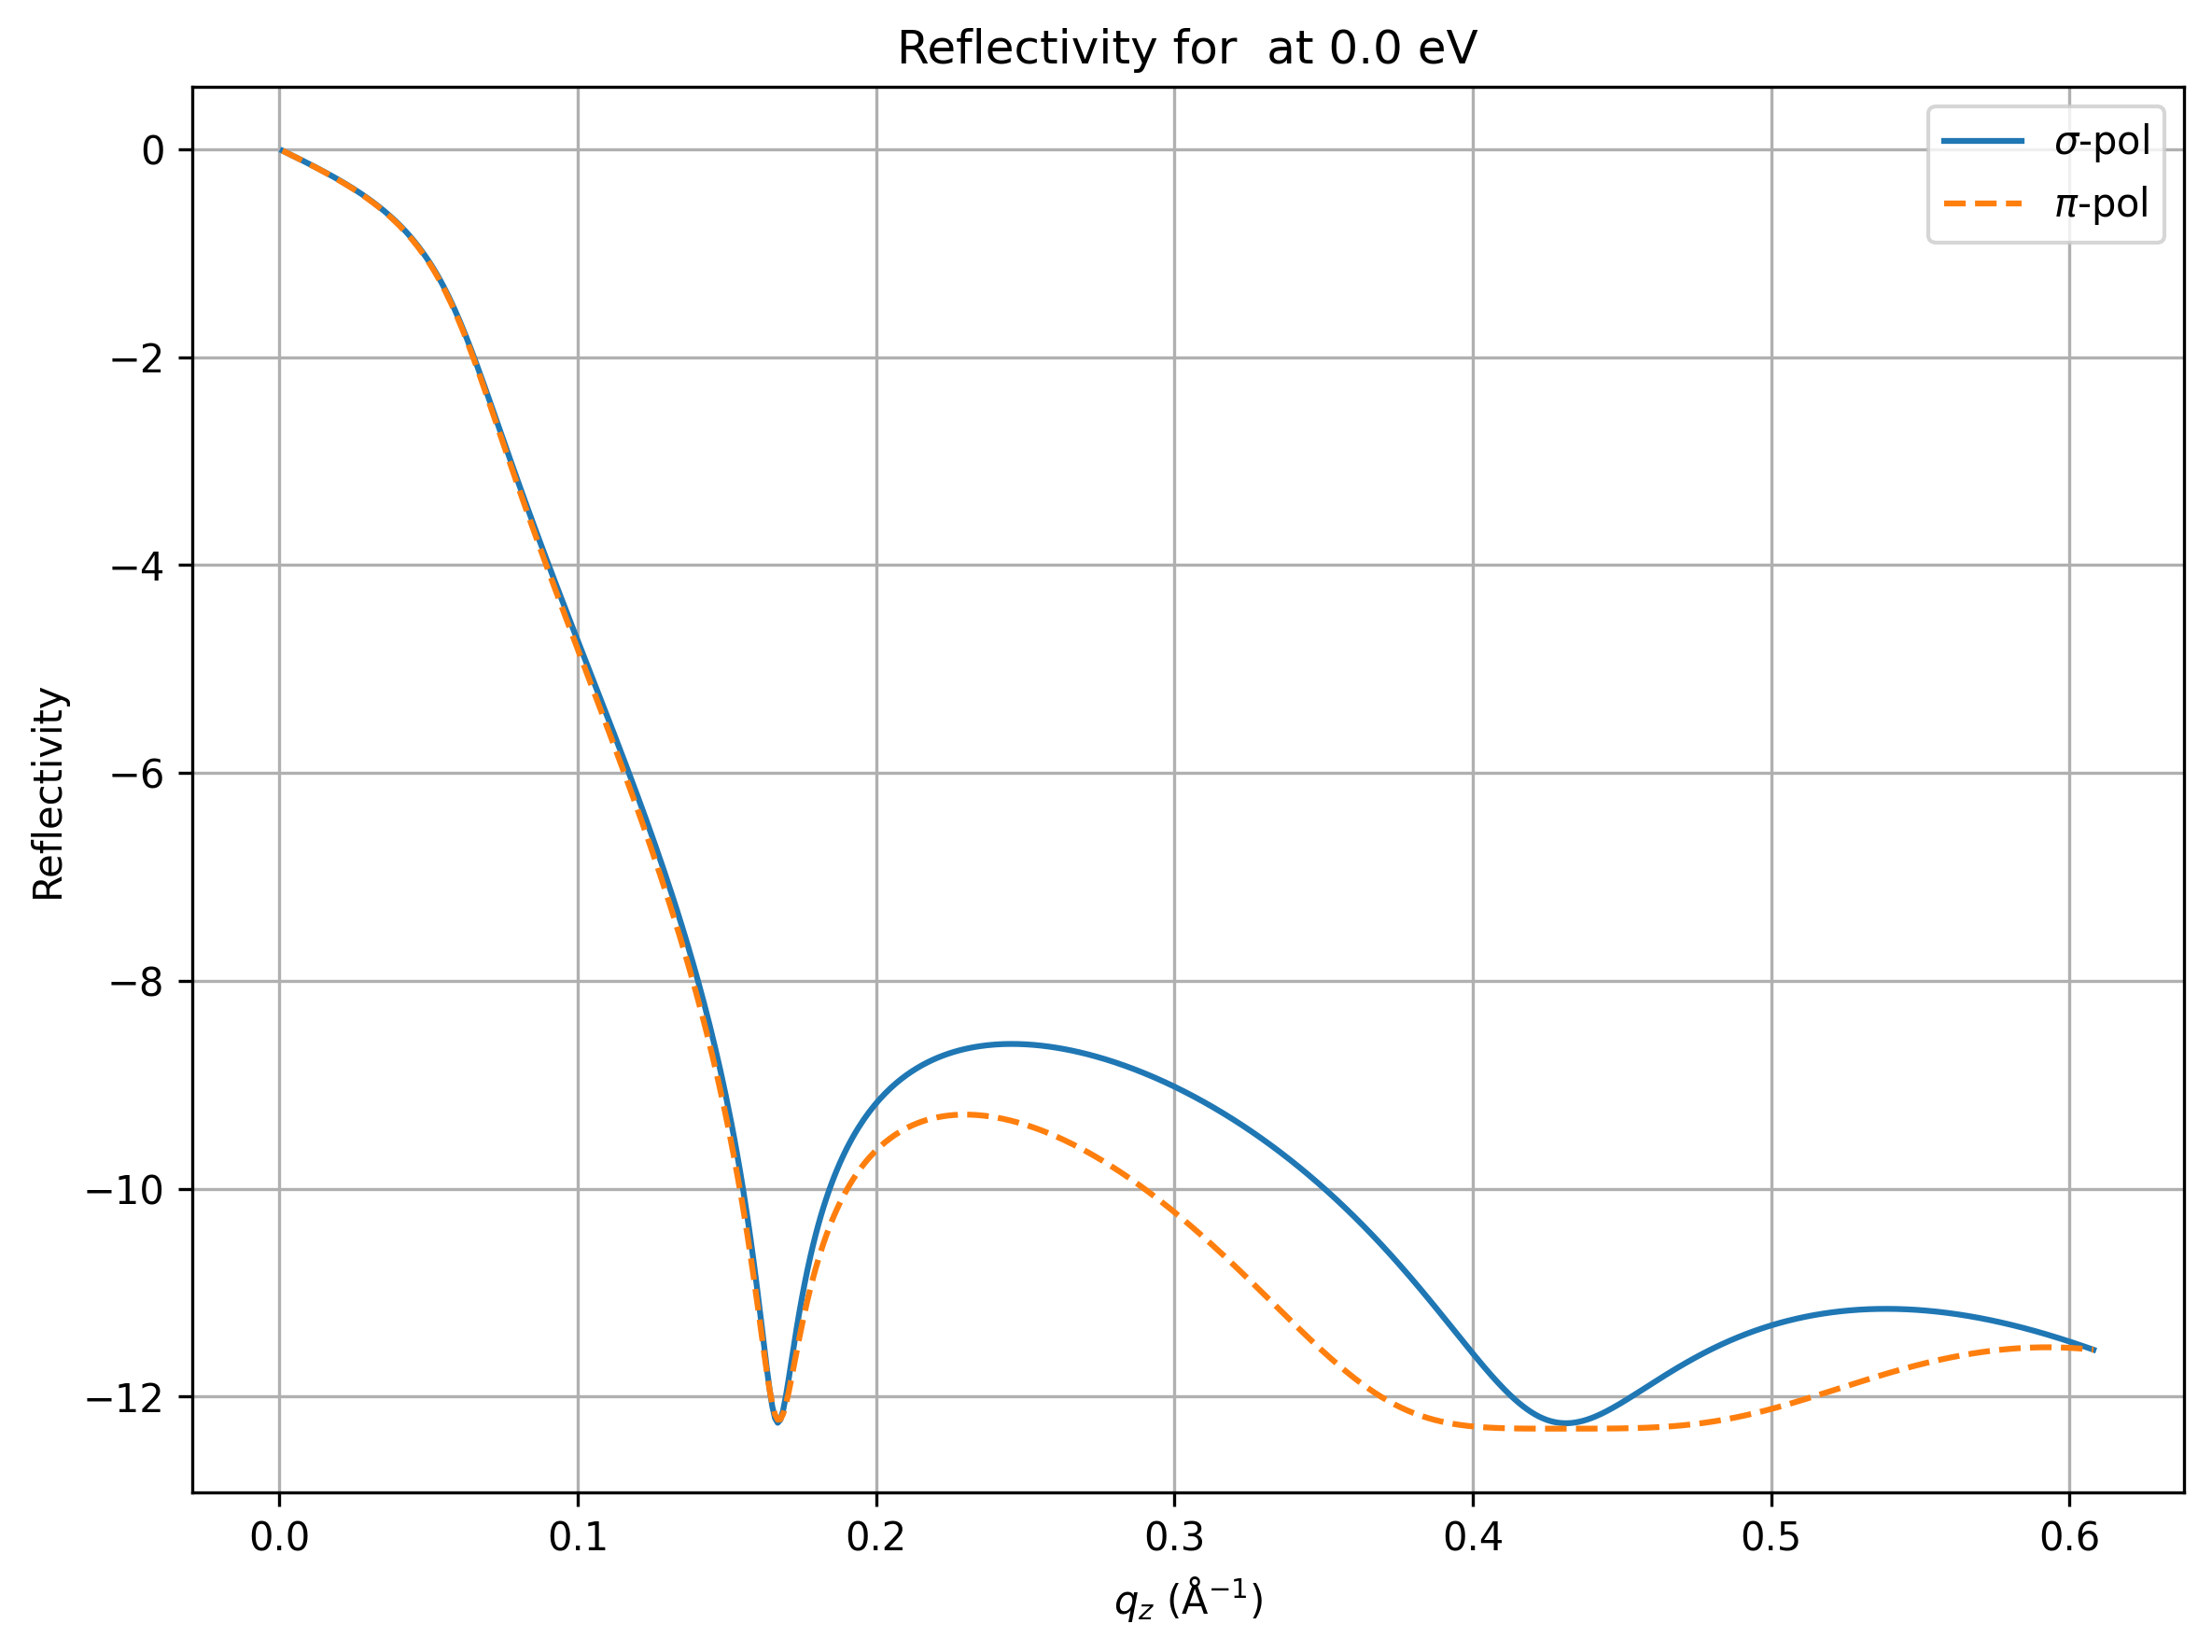

In [12]:
set_compound_params(model.structure, fit=True)
comp_SrTiO3.thickness.fit = False

optimizer = LeastSquaresOptimizer()
fitter = RXRFitter(model, experimental_data, optimizer)


init_params = model.parameters_container.get_fit_vector()
print(f"Initial parameters: {init_params}")
for param in model.parameters_container.parameters:
    if param.fit:
        print(f"{param.name}: {param.value}")

start_time = time.time()
result = fitter.fit(init_params, [])
end_time = time.time()

print(f"Fitting time: {end_time - start_time:.2f} seconds")
print(f"Fitting result: {result}")
print(f"Fitted parameters: {model.parameters_container.get_fit_vector()}")


final_ref = model.compute_reflectivity(qz, E_eV)
plot_reflectivity(final_ref.qz, final_ref.R_s, final_ref.R_p, final_ref.energy, "")

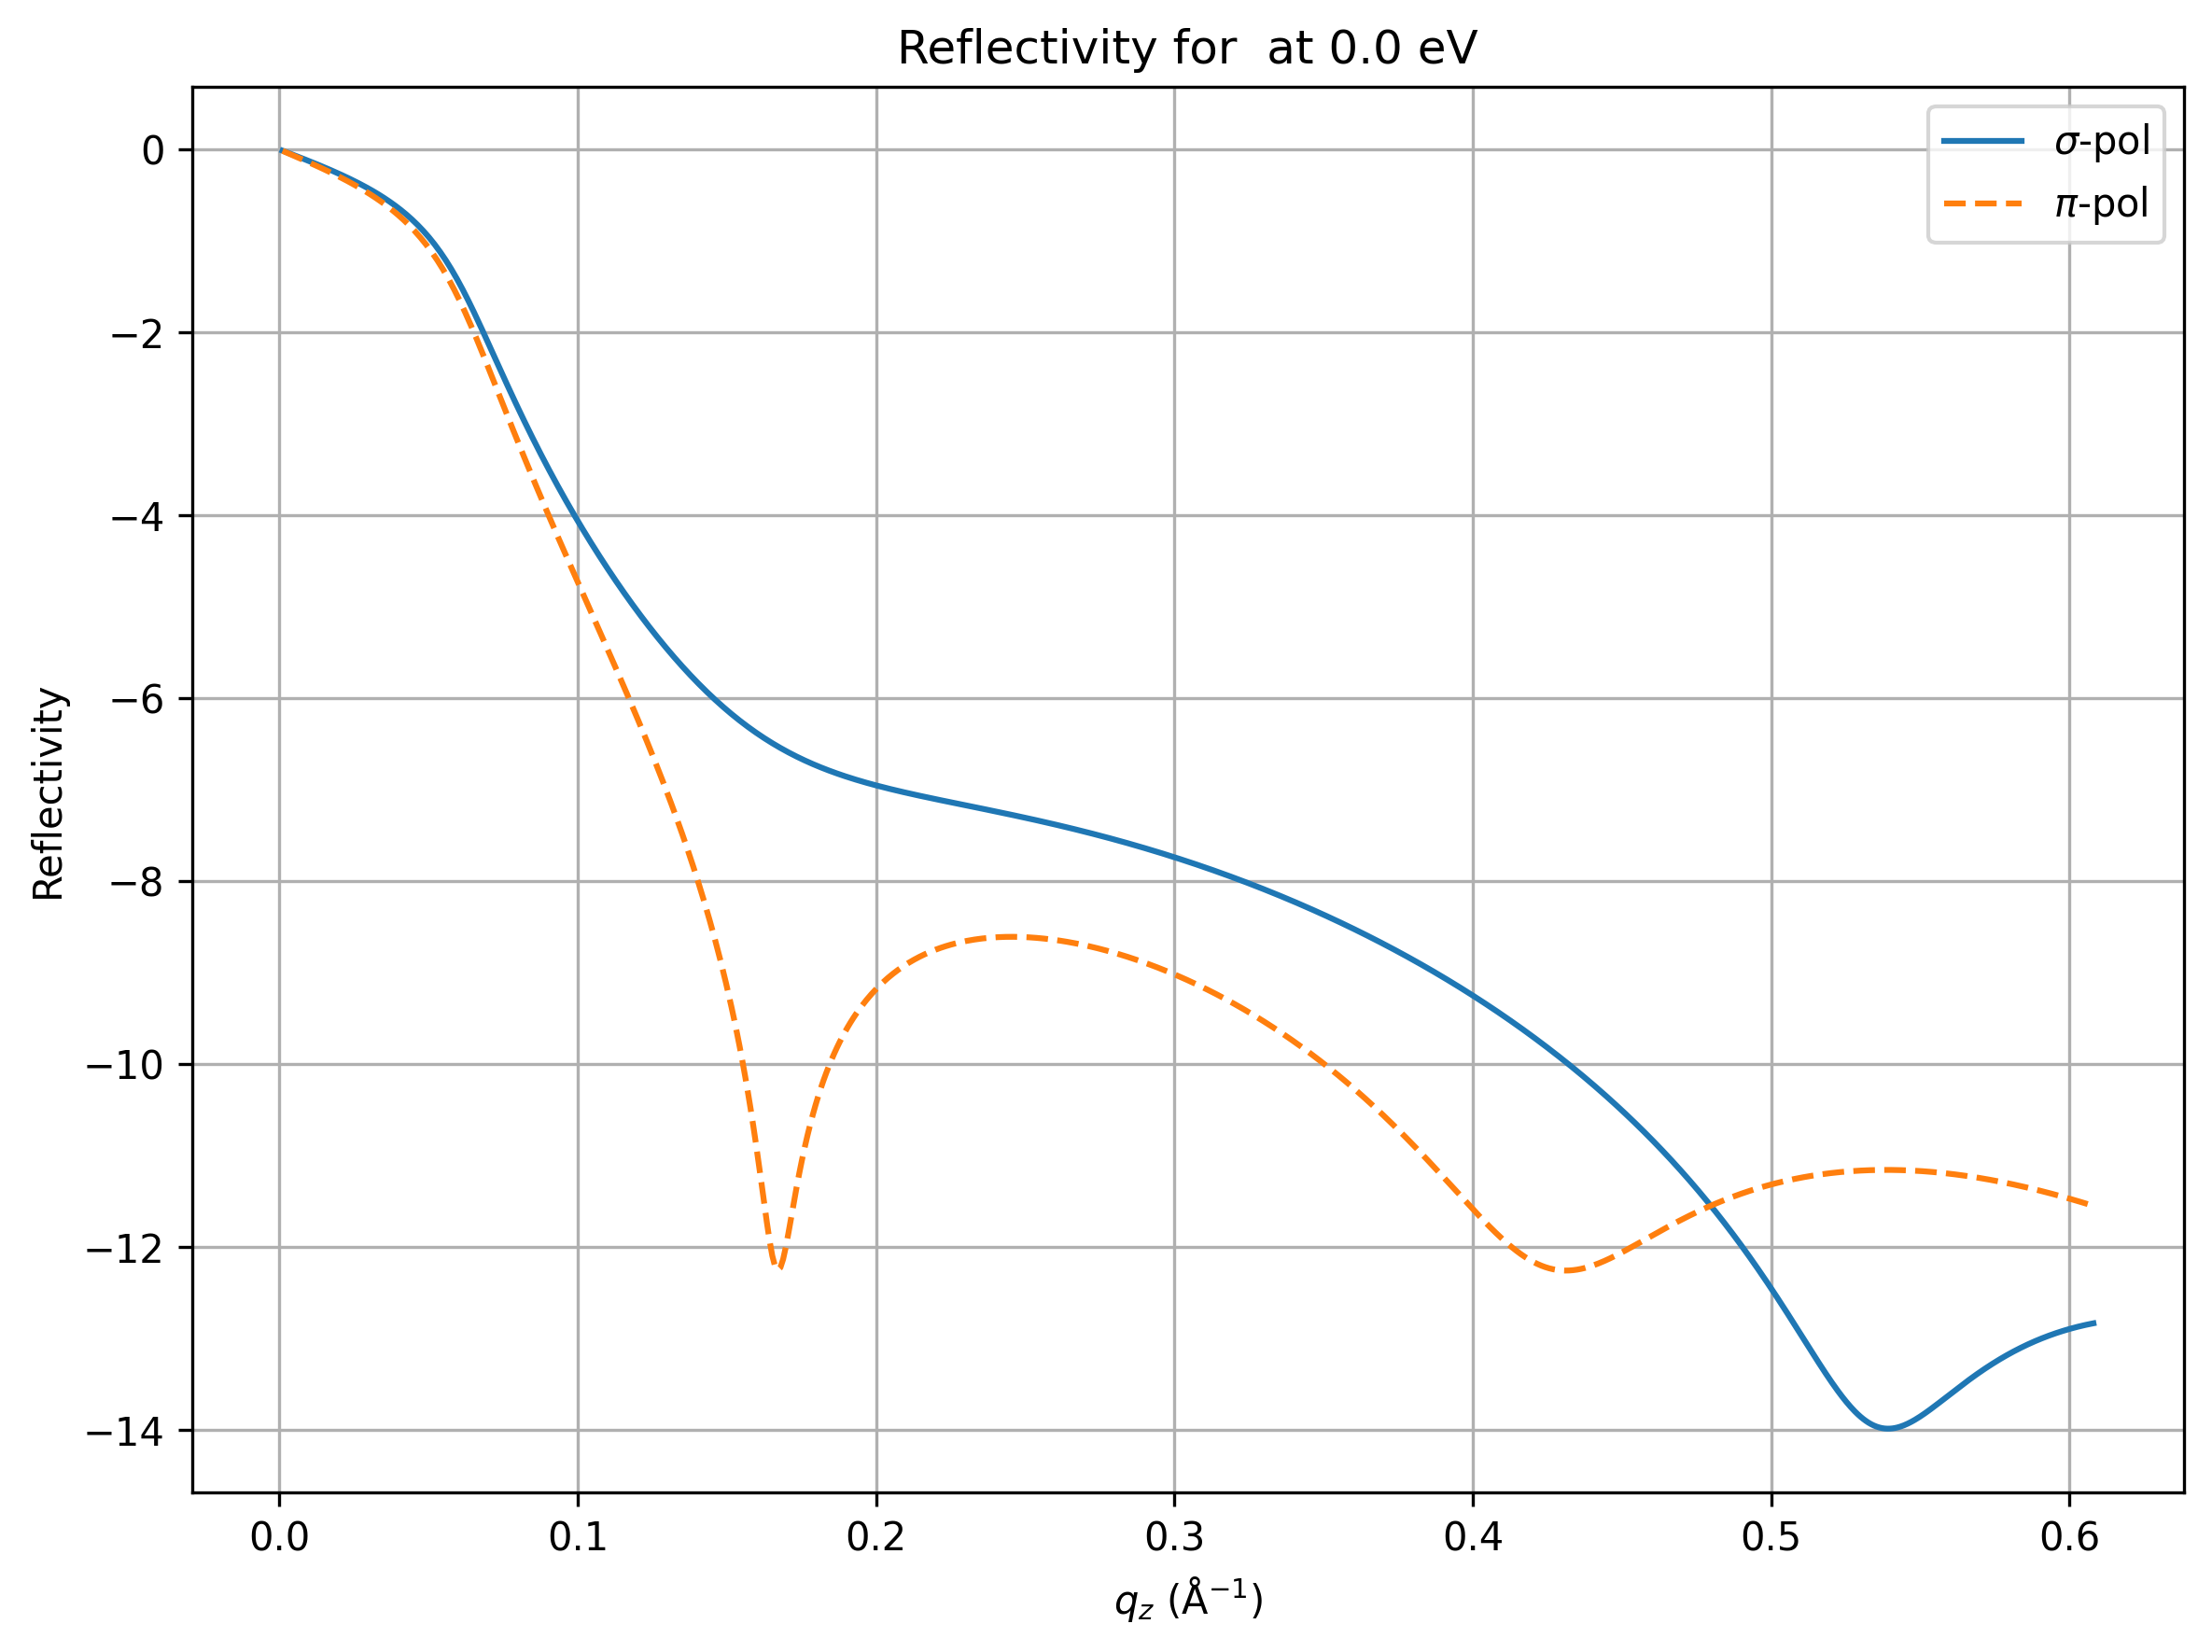

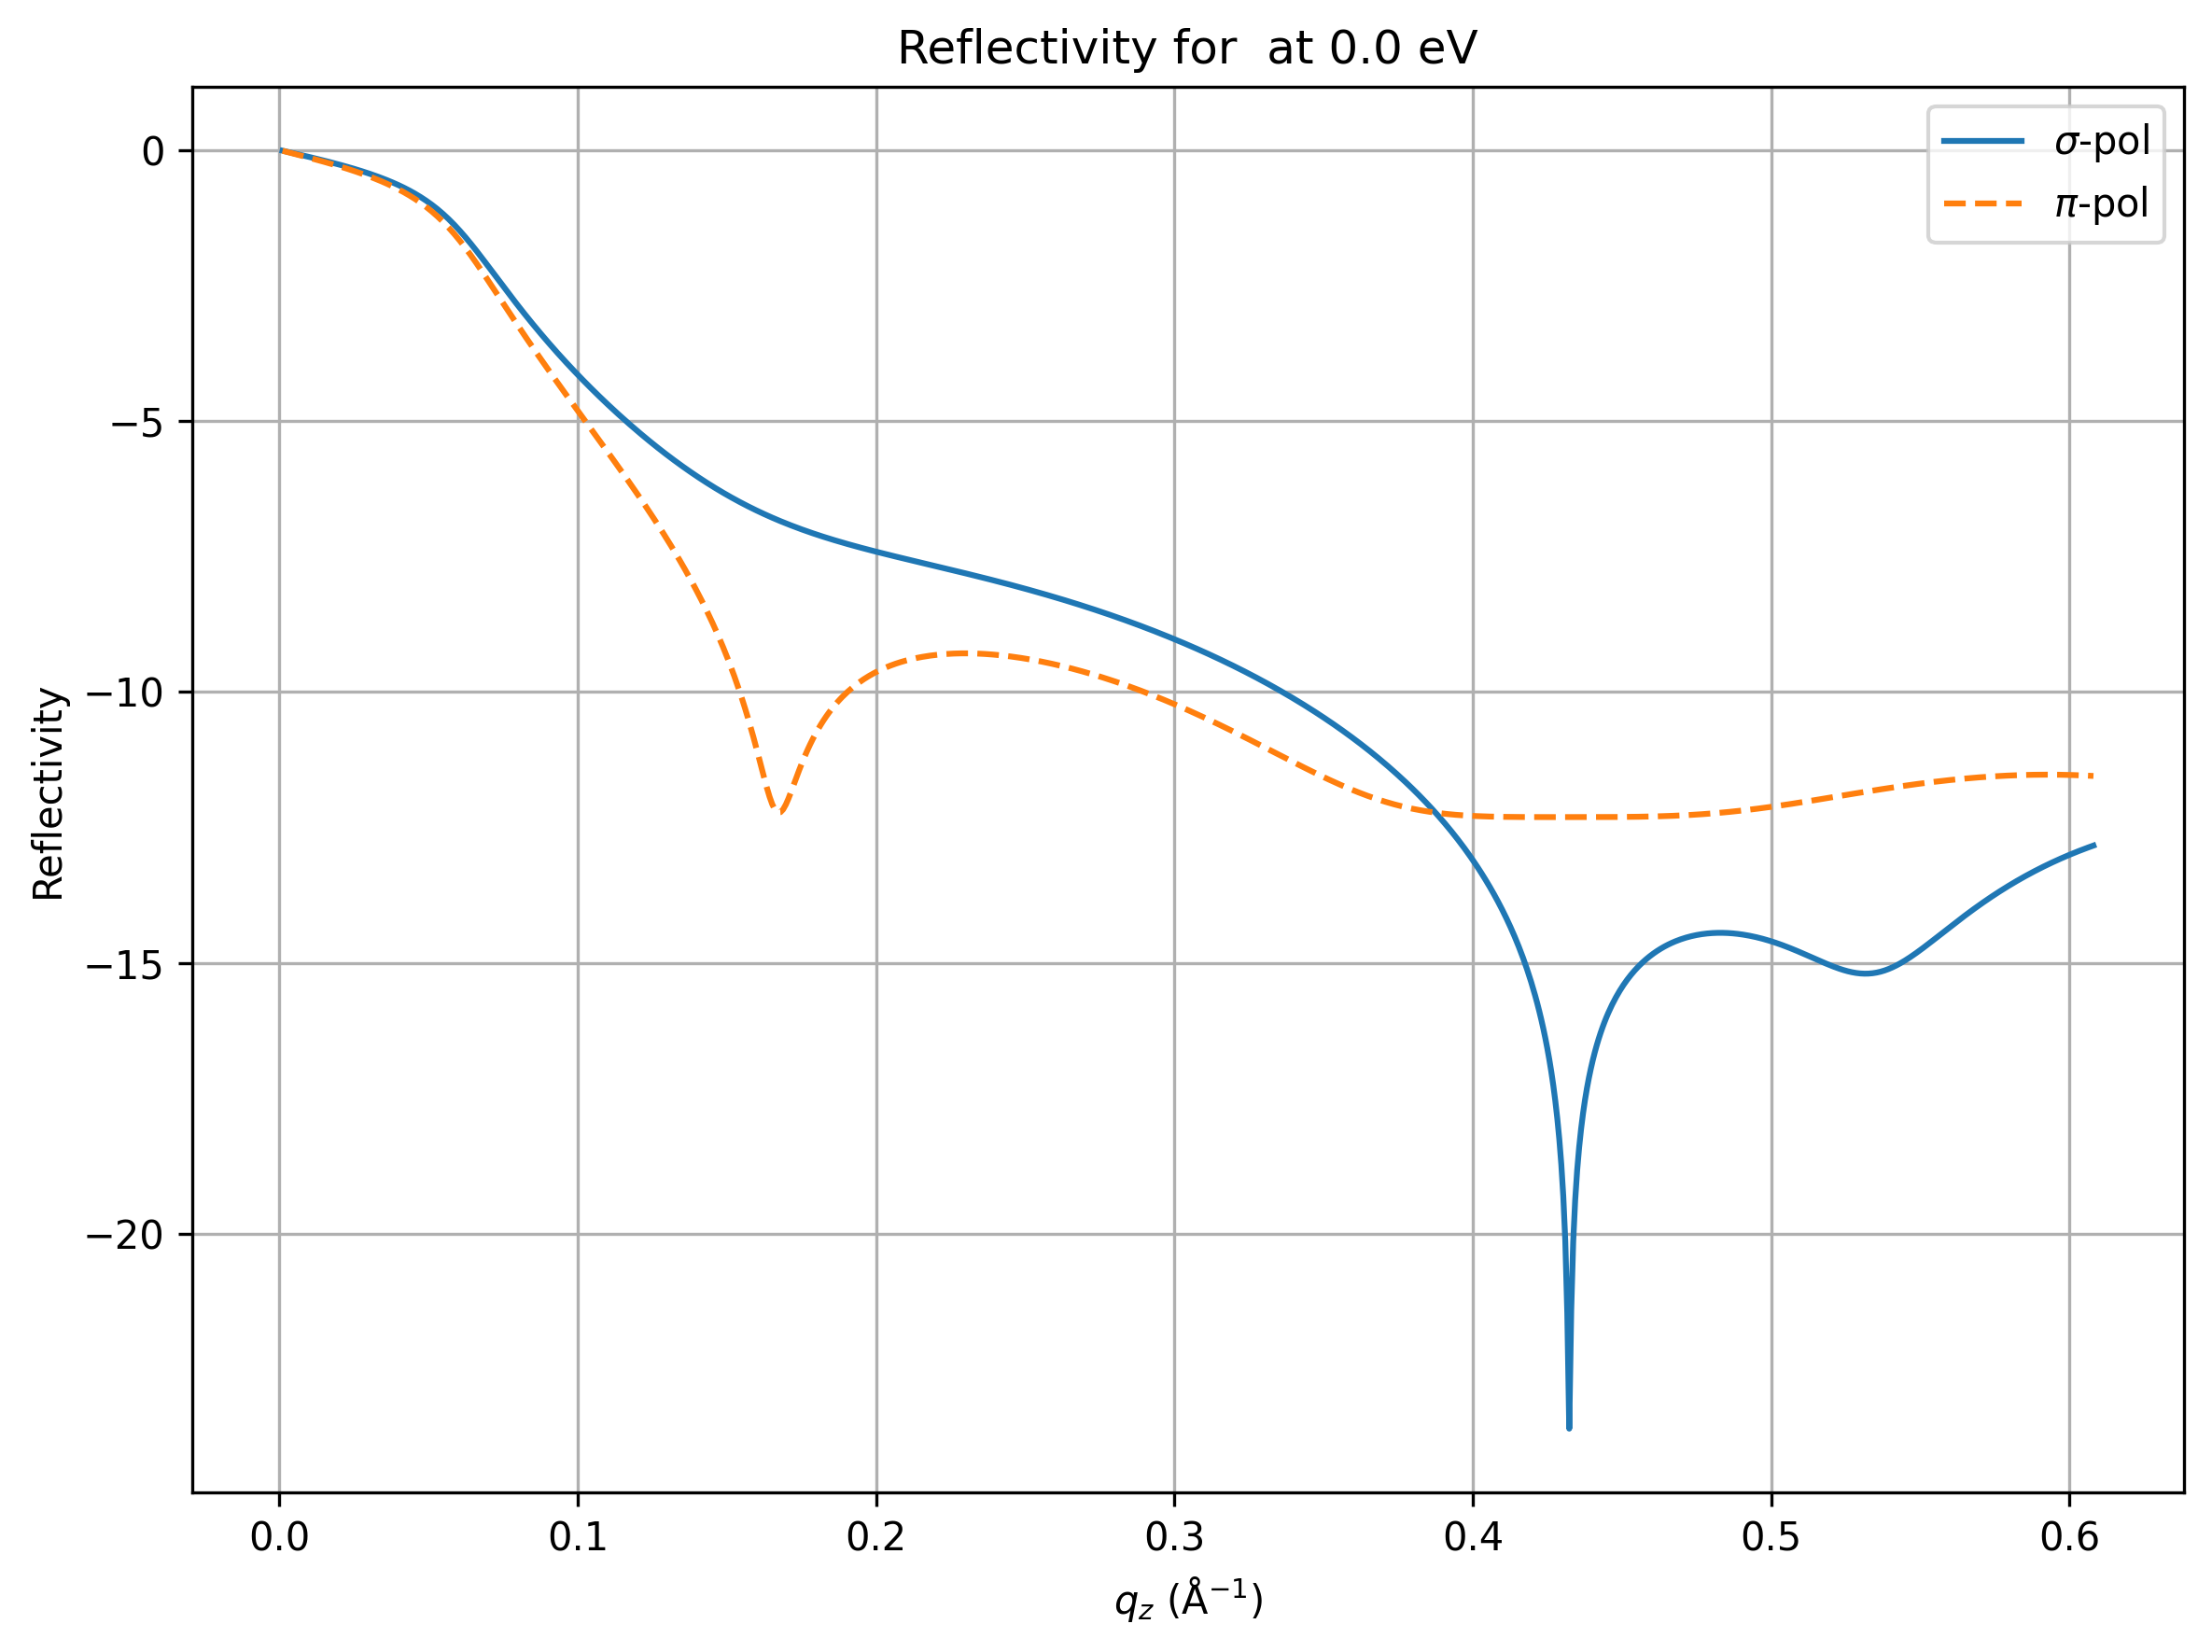

In [13]:
plot_reflectivity(experimental_data.qz, experimental_data.R_s, final_ref.R_s, final_ref.energy, "")
plot_reflectivity(experimental_data.qz, experimental_data.R_p, final_ref.R_p, final_ref.energy, "")
